In [16]:
import os
import zipfile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from google.colab import drive
import glob



In [17]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Define target directories
base_path = '/content/drive/MyDrive/pneumonia detectio sytem/dataset/chest_xray'
target_folders = {
    'train': os.path.join(base_path, 'train/NOT_CHEST'),
    'val': os.path.join(base_path, 'val/NOT_CHEST'),
    'test': os.path.join(base_path, 'test/NOT_CHEST')
}
for folder in target_folders.values():
    os.makedirs(folder, exist_ok=True)


In [19]:
# Image augmentation
datagen_args = dict(rescale=1./255)
train_datagen = ImageDataGenerator(
    **datagen_args,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(**datagen_args)

train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')


In [20]:
#  SafeDirectoryIterator: A wrapper around Keras' directory iterator
# to safely skip unreadable/corrupt images during training.

class SafeDirectoryIterator(tf.keras.utils.Sequence):
    def __init__(self, generator, directory, **kwargs):
        # Extract parameters or use defaults
        self.batch_size = kwargs.get("batch_size", 32)
        self.target_size = kwargs.get("target_size", (250, 250))
        self.class_mode = kwargs.get("class_mode", 'categorical')
        self.shuffle = kwargs.get("shuffle", True)

        # Initialize the underlying generator using flow_from_directory
        self.generator = generator.flow_from_directory(
            directory,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode=self.class_mode,
            shuffle=self.shuffle
        )

    def __len__(self):
        # Return the total number of batches per epoch
        return len(self.generator)

    def __getitem__(self, index):
        # Safely fetch a batch of data, skip bad images
        try:
            return self.generator[index]  # Try normal behavior
        except (UnidentifiedImageError, OSError, ValueError) as e:
            # If a corrupt image is encountered, print warning and fetch next batch
            print(f"⚠️ Skipped bad image in batch {index} due to error: {e}")
            next_index = (index + 1) % len(self.generator)  # Wrap around if needed
            return self.__getitem__(next_index)  # Try next batch

    def on_epoch_end(self):
        # Called automatically at the end of each epoch to reshuffle data if needed
        self.generator.on_epoch_end()


In [21]:
# Create generators
train_generator = SafeDirectoryIterator(train_datagen, train_dir)
val_generator = SafeDirectoryIterator(val_test_datagen, val_dir)
test_generator = SafeDirectoryIterator(val_test_datagen, test_dir, shuffle=False)



Found 4758 images belonging to 3 classes.
Found 483 images belonging to 3 classes.
Found 869 images belonging to 3 classes.


In [22]:
# Compute class weights
y_train = train_generator.generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [23]:

# =======================
# Phase 1: Warm-up Training
# =======================

# Load base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_model.trainable = False  # Freeze all layers for warm-up

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile for warm-up
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),  # Higher LR for new layers
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

# Warm-up training (only dense layers learn)
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# =======================
# Phase 2: Fine-tuning
# =======================

# Unfreeze last 40 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Compile for fine-tuning (smaller LR)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.6981 - loss: 0.7026

149/149 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6988 - loss: 0.7007 - val_accuracy: 0.9959 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8969 - loss: 0.2244

149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 809ms/step - accuracy: 0.8969 - loss: 0.2244 - val_accuracy: 0.9959 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9038 - loss: 0.2009

149/149 ━━━━━━━━━━━━━━━━━━━━ 119s 798ms/step - accuracy: 0.9038 - loss: 0.2009 - val_accuracy: 0.9959 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 810ms/step - accuracy: 0.9118 - loss: 0.1887 - val_accuracy: 0.9917 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9079 - loss: 0.2011

149/149 ━━━━━━━━━━━━━━━━━━━━ 119s 800ms/step - accuracy: 0.9079 - loss: 0.2011 - val_accuracy: 0.9959 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.7413 - loss: 0.9674

149/149 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7421 - loss: 0.9641 - val_accuracy: 0.9959 - val_loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9299 - loss: 0.1585

149/149 ━━━━━━━━━━━━━━━━━━━━ 125s 837ms/step - accuracy: 0.9300 - loss: 0.1585 - val_accuracy: 0.9959 - val_loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9386 - loss: 0.1330

149/149 ━━━━━━━━━━━━━━━━━━━━ 122s 819ms/step - accuracy: 0.9387 - loss: 0.1330 - val_accuracy: 0.9979 - val_loss: 0.0047 - learning_rate: 1.0000e-04
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 122s 815ms/step - accuracy: 0.9381 - loss: 0.1260 - val_accuracy: 0.9979 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9570 - loss: 0.0944

149/149 ━━━━━━━━━━━━━━━━━━━━ 123s 825ms/step - accuracy: 0.9570 - loss: 0.0944 - val_accuracy: 0.9979 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9663 - loss: 0.0806

149/149 ━━━━━━━━━━━━━━━━━━━━ 122s 816ms/step - accuracy: 0.9663 - loss: 0.0806 - val_accuracy: 0.9979 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 7/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 813ms/step - accuracy: 0.9676 - loss: 0.0814 - val_accuracy: 0.9979 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 8/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9741 - loss: 0.0682

149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 810ms/step - accuracy: 0.9741 - loss: 0.0683 - val_accuracy: 0.9979 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 9/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.9657 - loss: 0.0768

149/149 ━━━━━━━━━━━━━━━━━━━━ 120s 807ms/step - accuracy: 0.9657 - loss: 0.0768 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 10/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9748 - loss: 0.0608

149/149 ━━━━━━━━━━━━━━━━━━━━ 120s 804ms/step - accuracy: 0.9748 - loss: 0.0608 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 11/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9748 - loss: 0.0614

149/149 ━━━━━━━━━━━━━━━━━━━━ 123s 825ms/step - accuracy: 0.9748 - loss: 0.0614 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 12/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9776 - loss: 0.0586
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 812ms/step - accuracy: 0.9776 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 13/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 120s 803ms/step - accuracy: 0.9818 - loss: 0.0436 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 5.0000e-05
Epoch 14/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9822 - loss: 0.0426
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
149/149 ━━━━━━━━━━━━━━━━━━━━ 119s 795ms/step - accuracy: 0.9822 - loss: 0.0426 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 5.0000e-05
Epoch 15/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 118s 793ms/step - a

149/149 ━━━━━━━━━━━━━━━━━━━━ 122s 817ms/step - accuracy: 0.9843 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 8.6158e-04 - learning_rate: 2.5000e-05
Epoch 17/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 812ms/step - accuracy: 0.9854 - loss: 0.0411 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.5000e-05
Epoch 18/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9873 - loss: 0.0299
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
149/149 ━━━━━━━━━━━━━━━━━━━━ 123s 827ms/step - accuracy: 0.9873 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 2.5000e-05
Epoch 19/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 122s 820ms/step - accuracy: 0.9860 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 1.2500e-05
Epoch 20/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.9793 - loss: 0.0443
Epoch 20: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
149/149 ━━━━━━━━━━━━━━━━━━━━ 124s 835ms/step 

In [24]:
# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 603ms/step - accuracy: 0.9377 - loss: 0.2220
Test Accuracy: 95.40%


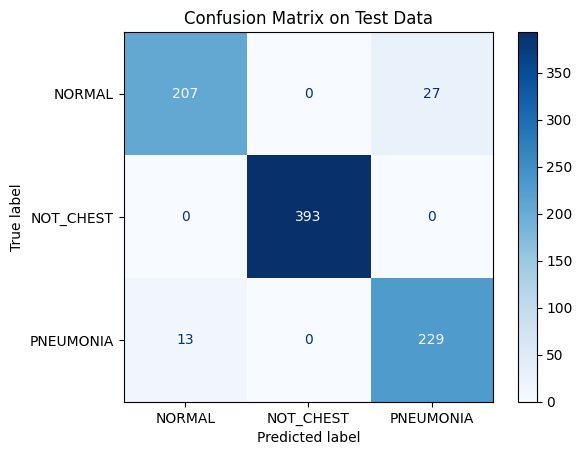

In [25]:
# Confusion Matrix (Accurate with SafeDirectoryIterator)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

# Iterate through test batches safely
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use actual class names in correct order
class_names = list(train_generator.generator.class_indices.keys())

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Data")
plt.show()



In [26]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\n📊 Classification Report:\n")
print(report)



📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.88      0.91       234
   NOT_CHEST       1.00      1.00      1.00       393
   PNEUMONIA       0.89      0.95      0.92       242

    accuracy                           0.95       869
   macro avg       0.95      0.94      0.94       869
weighted avg       0.95      0.95      0.95       869



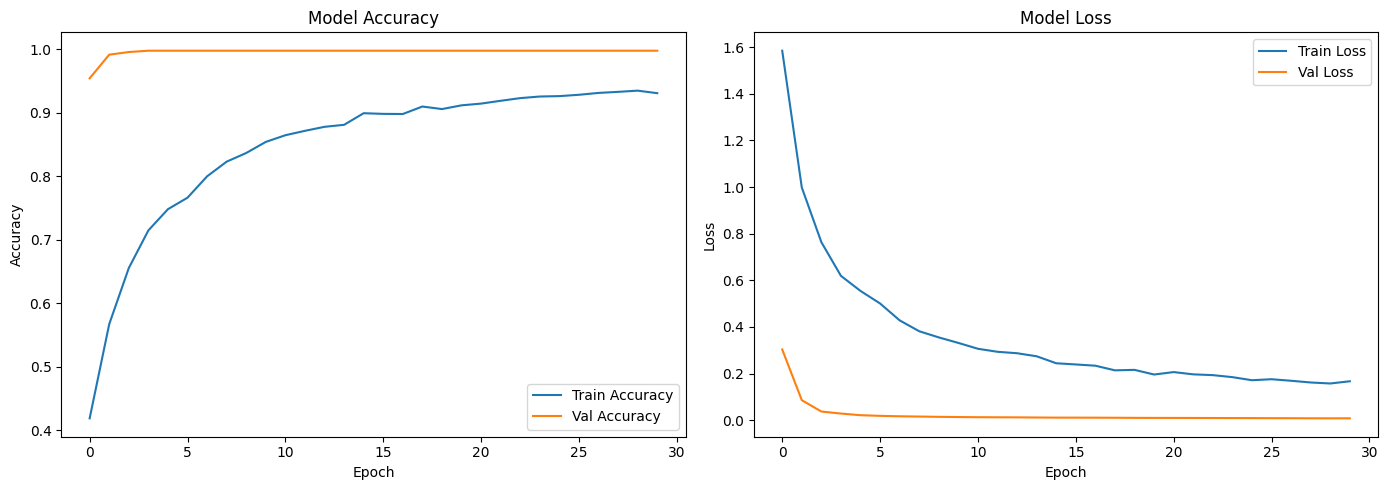

In [27]:
# Plot results
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((250, 250))
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]

        class_names = ['NORMAL', 'NOT_CHEST', 'PNEUMONIA']

        print("\n🔍 Prediction Scores:")
        for i, score in enumerate(prediction):
            print(f"{class_names[i]}: {score*100:.2f}%")

        predicted_index = np.argmax(prediction)
        confidence = prediction[predicted_index]
        label = class_names[predicted_index]

        plt.imshow(img)
        plt.axis('off')
        details = "\n".join([
            f"{class_names[i]}: {prediction[i]*100:.1f}%" for i in range(len(class_names))
        ])
        plt.title(f'Prediction: {label} ({confidence * 100:.2f}%)\n{details}')
        plt.show()

    except Exception as e:
        print(f"Error during classification: {e}")



In [29]:

classify_local_image(image_path='/content/drive/MyDrive/pneumonia detectio sytem/dataset/chest_xray/val/NOT_CHEST/01a857d803.jpg')

KeyboardInterrupt: 

In [ ]:
# Save and download model
!mkdir -p models
model.save('models/model.h5')



In [ ]:
from google.colab import files
files.download("models/model.h5")